# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [4]:
PATH = "Data/house-prices-advanced-regression-techniques/"

df_raw = pd.read_feather('tmp/regression')
df_trn, y_trn, nas = proc_df(df_raw, y_fld='SalePrice')

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(df_trn, y_trn, test_size=0.3)

In [7]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [12]:
labels = ['level_0', 'index']
df_raw.drop(labels, inplace=True, axis=1); 

ValueError: labels ['level_0' 'index'] not contained in axis

In [13]:
df_raw.T

,0,1,2,3,4,5,6,7,8,9,...,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458
Id,1,2,3,4,5,6,7,8,9,10,...,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460
MSSubClass,60,20,60,70,60,50,20,60,50,190,...,90,20,180,20,20,60,20,70,20,20
MSZoning,RL,RL,RL,RL,RL,RL,RL,RL,RM,RL,...,RL,RL,RM,RL,FV,RL,RL,RL,RL,RL
LotArea,8450,9600,11250,9550,14260,14115,10084,10382,6120,7420,...,9000,9262,3675,17217,7500,7917,13175,9042,9717,9937
Street,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,...,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave
LotShape,Reg,Reg,IR1,IR1,IR1,IR1,Reg,IR1,Reg,Reg,...,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,...,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,...,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub
LotConfig,Inside,FR2,Inside,Corner,FR2,Inside,Inside,Corner,Inside,Corner,...,FR2,Inside,Inside,Inside,Inside,Inside,Inside,Inside,Inside,Inside
LandSlope,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,...,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [14]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07838806576230901, 0.1443239628515858, 0.960109254051312, 0.8790285117165312, 0.8570692021316927]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [15]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 14.3 ms


(11.711848528677663, 0.1799657843563279)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [16]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 56 ms, sys: 112 ms, total: 168 ms
Wall time: 172 ms


(11.711848528677663, 0.1799657843563279)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [18]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
17,OverallQual,0.277830
39,GrLivArea,0.166739
19,YearBuilt,0.094535
25,ExterQual,0.092356
31,TotalBsmtSF,0.046025
50,GarageCars,0.040738
51,GarageArea,0.040201
36,1stFlrSF,0.037763
20,YearRemodAdd,0.025538
49,Fireplaces,0.022519


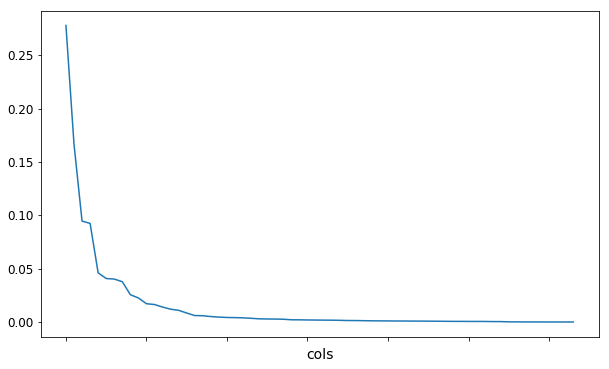

In [19]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [20]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

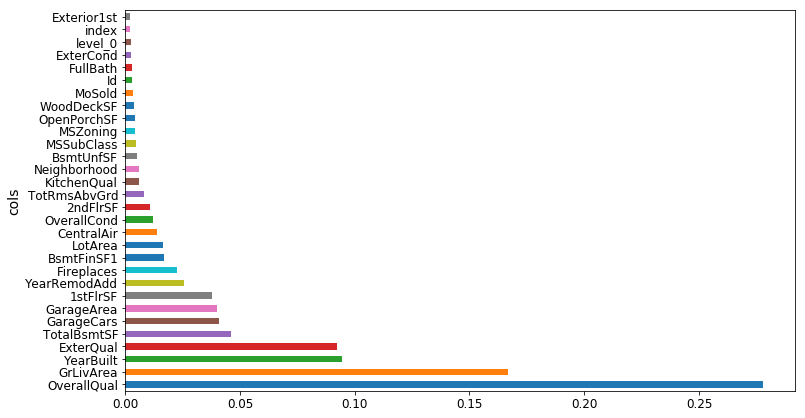

In [21]:
plot_fi(fi[:30]);

In [22]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

19

In [27]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid, y_train, y_valid = train_test_split(df_keep, y_trn, test_size=0.3)

In [28]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0865831346557783, 0.12895896619267422, 0.9532729478801111, 0.8943882637413723, 0.8605819929266212]


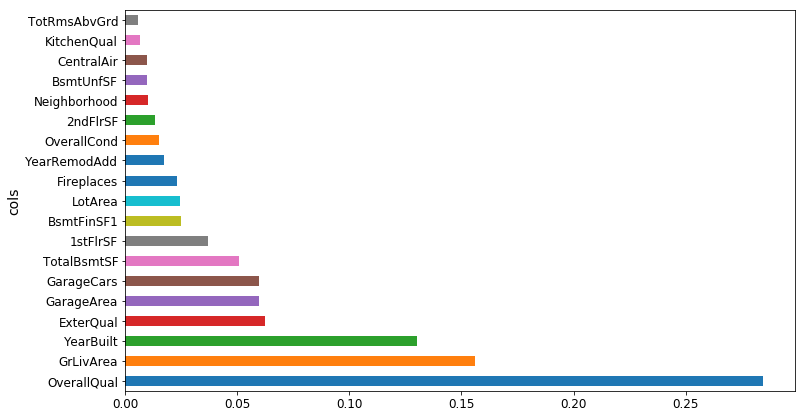

In [29]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

In [30]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid, y_train, y_valid = train_test_split(df_trn2, y_trn, test_size=0.3)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07822713281567116, 0.14468311870810602, 0.9623448940757495, 0.8628803268874063, 0.8583819885168069]


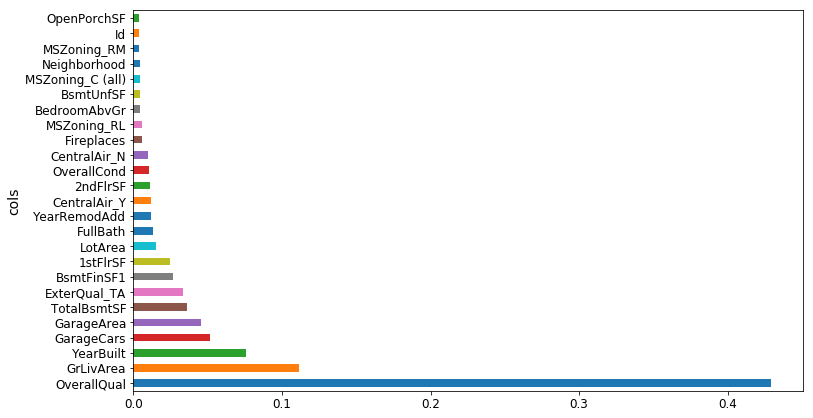

In [31]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [32]:
from scipy.cluster import hierarchy as hc

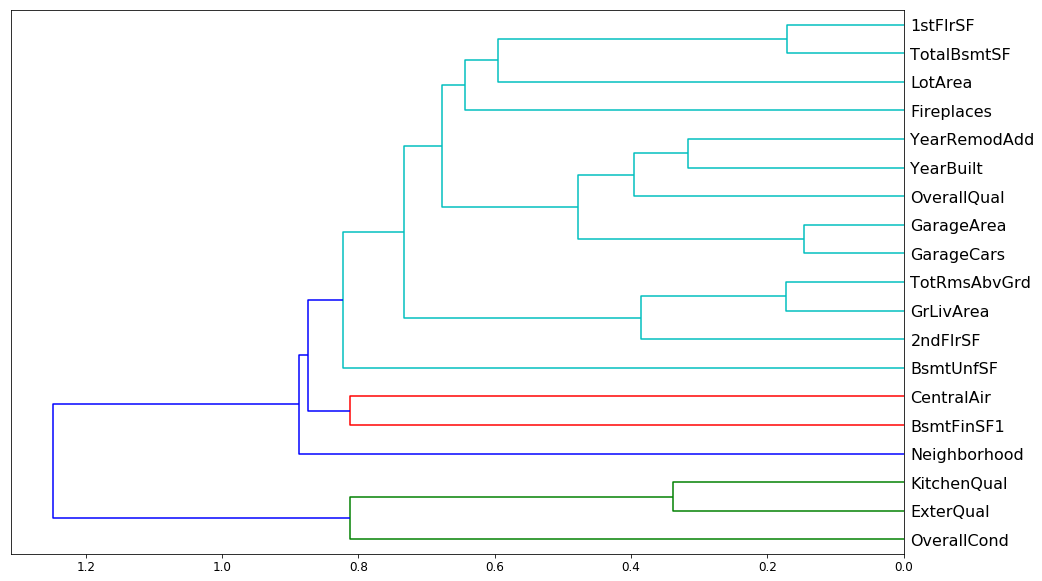

In [33]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [34]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 300
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [35]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [36]:
get_oob(df_keep)

0.8616320503564634

Now we try removing each variable one at a time.

In [39]:
for c in ('1stFlrSF','TotalBsmtSF','YearRemodAdd','YearBuilt','GarageArea','GarageCars',
          'TotRmsAbvGrd','GrLivArea','CentralAir','BsmtFinSF1','KitchenQual','ExterQual'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

1stFlrSF 0.8595026834098266
TotalBsmtSF 0.8634989706447416
YearRemodAdd 0.8616391714509741
YearBuilt 0.8577249153238299
GarageArea 0.8669391032367122
GarageCars 0.8601890797653399
TotRmsAbvGrd 0.8632105182960915
GrLivArea 0.8482085079050135
CentralAir 0.8565263108014913
BsmtFinSF1 0.8611892225449123
KitchenQual 0.8637563351561569
ExterQual 0.865378744218532


It looks like we can try one from each group for removal. Let's see what that does.

In [45]:
to_drop = ['TotalBsmtSF','GarageCars', 'ExterQual', 'GrLivArea']
get_oob(df_keep.drop(to_drop, axis=1))

0.8578827212112865

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [46]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [47]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [48]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [49]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.08866882314185955, 0.14620991212276882, 0.951390388223804, 0.8584433838957086, 0.856030306466688]


# Partial dependence

In [50]:
from pdpbox import pdp
from plotnine import *

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [51]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

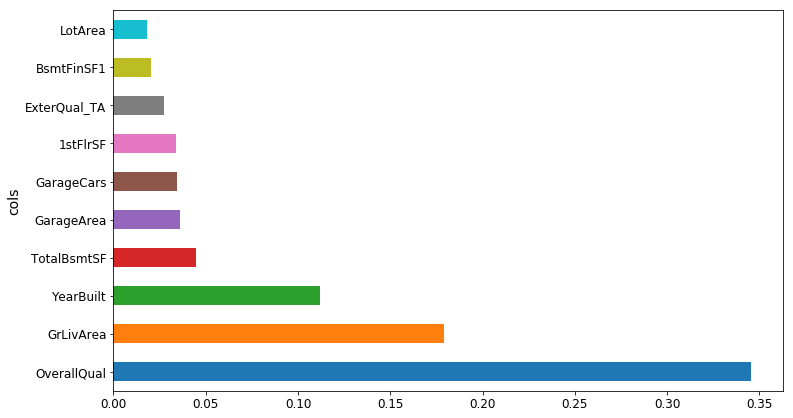

In [52]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

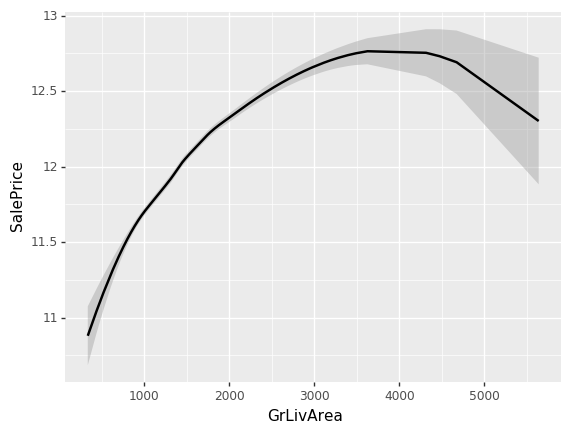

<ggplot: (8785474353493)>

In [57]:
ggplot(df_raw, aes('GrLivArea', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [62]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, df_trn2, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

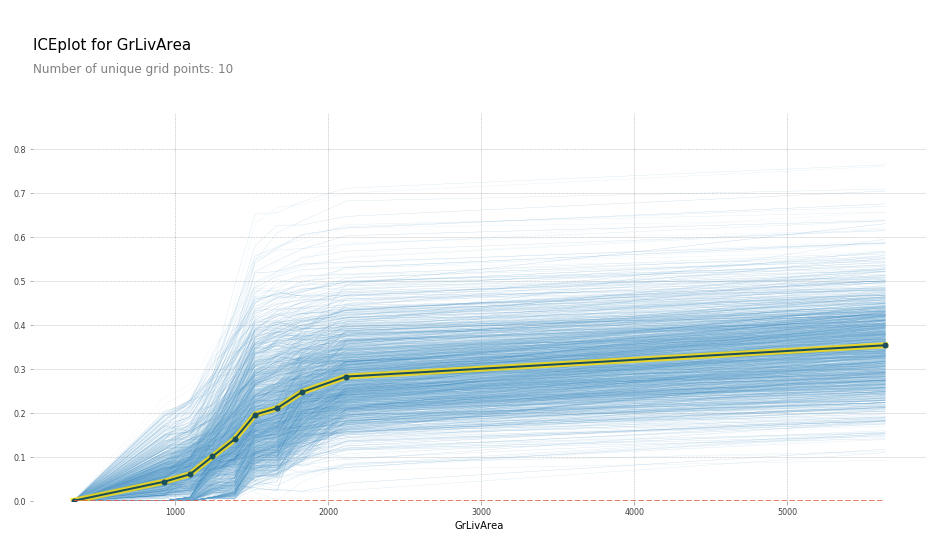

In [63]:
plot_pdp('GrLivArea')

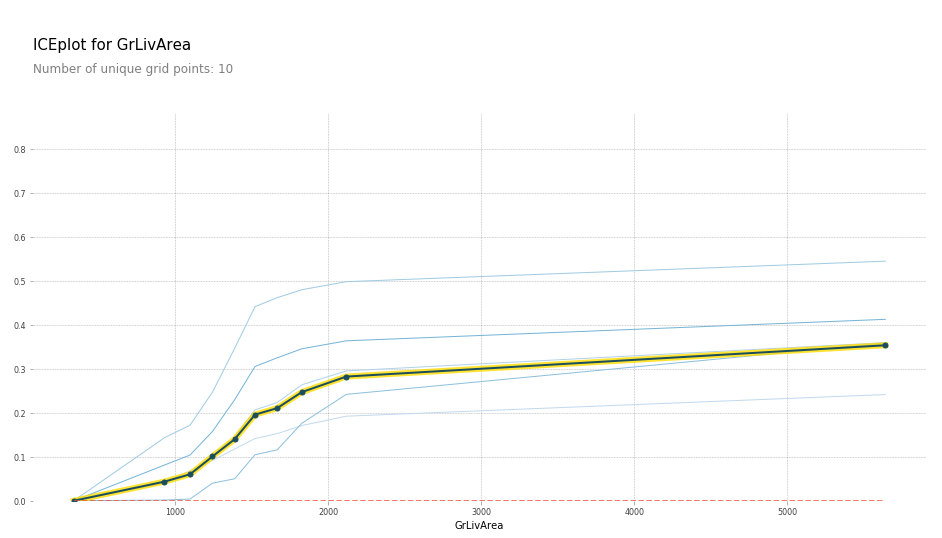

In [64]:
plot_pdp('GrLivArea', clusters=5)

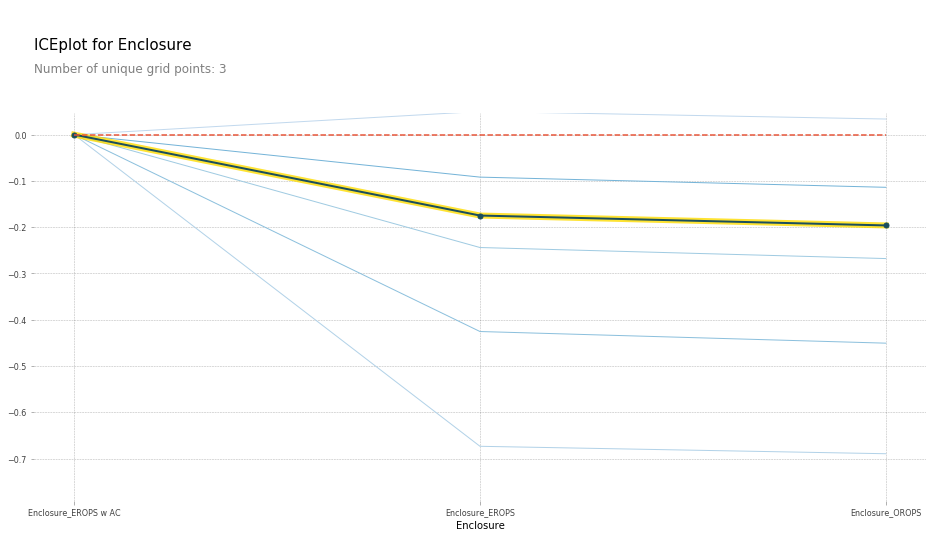

In [55]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

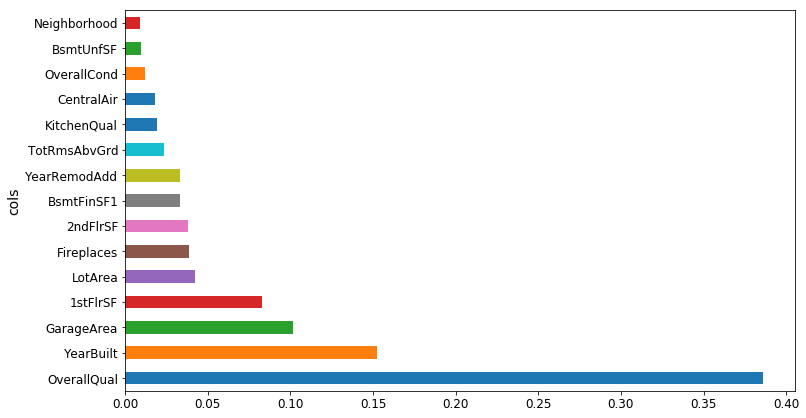

In [65]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [66]:
from treeinterpreter import treeinterpreter as ti

In [67]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [68]:
row = X_valid.values[None,0]; row

array([[   6, 1974,  540,  943, 1974,    1,  442, 9120,    2,    6,  933,    8,    3,   15,  459]])

In [69]:
prediction, bias, contributions = ti.predict(m, row)

In [70]:
prediction[0], bias[0]

(12.0579337126774, 12.022375772327411)

In [71]:
idxs = np.argsort(contributions[0])

In [72]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('OverallQual', 6, -0.07108367962770772),
 ('YearBuilt', 1974, -0.07083152825618244),
 ('1stFlrSF', 943, -0.047937843108186454),
 ('YearRemodAdd', 1974, -0.026202831406188933),
 ('LotArea', 9120, -0.012554241841119262),
 ('Neighborhood', 'NWAmes', -0.001739315216245263),
 ('BsmtUnfSF', 459, -0.0004910824044078499),
 ('OverallCond', 6, 0.0009984698850139307),
 ('BsmtFinSF1', 442, 0.008272322336117677),
 ('CentralAir', 'Y', 0.008568659451829986),
 ('KitchenQual', 'Gd', 0.016740088242752506),
 ('TotRmsAbvGrd', 8, 0.02252123543940123),
 ('GarageArea', 540, 0.043327321209151747),
 ('Fireplaces', 1, 0.06452359387880335),
 ('2ndFlrSF', 933, 0.10144677176695831)]

In [73]:
contributions[0].sum()

0.03555794034999079

# Extrapolation

In [67]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [68]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999925210345902

In [69]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.759363
5,saleElapsed,0.172454
12,MachineID,0.054914
19,saleDayofyear,0.003248
7,fiModelDesc,0.002918
4,ModelID,0.002269
0,YearMade,0.001870
6,fiSecondaryDesc,0.000792
11,fiModelDescriptor,0.000500
1,Coupler_System,0.000402


In [70]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [71]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [72]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [73]:
x.drop(feats, axis=1, inplace=True)

In [74]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9788669367404176

In [75]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.239407
0,YearMade,0.183818
16,saleDayofyear,0.152271
4,ModelID,0.080053
6,fiModelDesc,0.064548
15,saleDay,0.056938
14,state,0.054535
3,fiProductClassDesc,0.034111
5,fiSecondaryDesc,0.023914
11,Hydraulics,0.021576


In [76]:
set_rf_samples(50000)

In [77]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [78]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20744931524463286, 0.24621582153410493, 0.9100587669251871, 0.8917370423515906, 0.8934595293361765]


In [79]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.2089347795838884, 0.24479193929426693, 0.9087660864526858, 0.8929856051871162, 0.8927129074718213]
saleElapsed
[0.21413127415111674, 0.2548036253319153, 0.9041714253566194, 0.8840530898630284, 0.8871246798515438]
MachineID
[0.2067882129942778, 0.24621778229058508, 0.9106311053490946, 0.891735318025837, 0.8950575429126839]
age
[0.20893254530917363, 0.2487764551333977, 0.9087680376887285, 0.8894734728360043, 0.8922694170285251]
YearMade
[0.20869090700523568, 0.2526816958707094, 0.9089789420128266, 0.8859761922265763, 0.8924711103002686]
saleDayofyear
[0.20846103285331502, 0.24460519952002374, 0.9091793519415536, 0.8931488149859204, 0.8932606469318405]


In [80]:
reset_rf_samples()

In [81]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13846443900989755, 0.21743738392048198, 0.9599307395297585, 0.91556618696562, 0.9094566374080939]


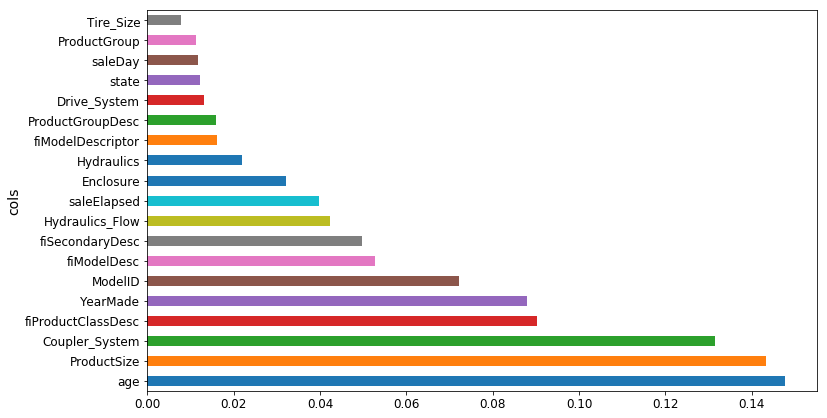

In [82]:
plot_fi(rf_feat_importance(m, X_train));

In [83]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [75]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 696 ms, sys: 32 ms, total: 728 ms
Wall time: 438 ms
[0.10522453223980263, 0.14901783185897652, 0.9315435661174765, 0.8529540658083592, 0.8623986502348203]


In [80]:
m = RandomForestRegressor(n_estimators=160, max_features=0.2, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 680 ms, sys: 24 ms, total: 704 ms
Wall time: 545 ms
[0.05447781252781833, 0.13932117272652056, 0.9816506964338135, 0.8714681427422908, 0.8705671538595985]


This techniques allowed us to place in top 5% of the competition! 